In [16]:

import os
import math
import random
import functools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from typing import List, Dict, Tuple

import skopt

import config
from config import *
from ms_io import mgf_io
from preprocessing import preprocessing
from cluster import similarity, masking, clustering, hierarchical
from eval import eval

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


## Initialization

In [2]:

spectra_filename = '../data/extracted_2d16b7f8-6954-4ba1-b5fa-3c467b43227d.mgf'
annotations_filename = '../data/annotations.tsv'

distance_matrix_filename = '../distance_matrix.npz'

max_prop_clust_incorrect = 0.01


In [3]:

config.parse((spectra_filename, annotations_filename))

if not os.path.isfile(spectra_filename):
    raise ValueError(f'Non-existing peak file (spectra_filename)')
if not os.path.isfile(annotations_filename):
    raise ValueError(f'Non-existing annotations file (annotations_filename)')
if distance_matrix_filename is not None:
    if not os.path.isfile(distance_matrix_filename):
        raise ValueError(f'Non-existing distance matrix file (distance_matrix_filename)')

# read file and process spectra
raw_spectra = mgf_io.get_spectra(source=spectra_filename)
spectra = list(preprocessing.process_all_spectra(raw_spectra, 
                                                config.min_peaks, config.min_mz_range,
                                                config.min_mz, config.max_mz,
                                                config.remove_precursor_tol,
                                                config.min_intensity, 
                                                config.max_peaks_used, config.scaling))
spectra = [spectrum for spectrum in spectra if spectrum is not None]
spectra.sort(key=lambda x: x.precursor_mz)
n_spectra = len(spectra)

scan_idx_list = [int(spec.identifier) for spec in spectra]

if distance_matrix_filename is not None:
    # read distance matrix file and create similarity matrix
    distance_matrix = similarity.load_matrix(distance_matrix_filename)
    similarity_matrix = similarity.similarity_to_distance(distance_matrix)
else:
    # calculate pairwise mod cos similarity
    similarity_matrix = similarity.create_mod_cos_similarity_matrix(spectra, config.fragment_tol)
    distance_matrix = similarity.similarity_to_distance(similarity_matrix)
    if config.export_dist_matrix:
        similarity.save_matrix(distance_matrix, 'distance_matrix.npz')

# create masked distance matrix for clustering based on precursor mass
mask = masking.generate_mask(spectra, config.precursor_tol)
masked_distance_matrix = similarity.similarity_to_distance(np.multiply(similarity_matrix, mask))
# deal with floating point inaccuracy 
# np.clip results in "ValueError: Linkage 'Z' uses the same cluster more than once." when plotting dendrogram
masked_distance_matrix = np.where(masked_distance_matrix>0, masked_distance_matrix, 0)


## Hyperparameter optimization

In [4]:

def run_clustering(eps: float, min_cluster_size: int, masked_dist_matrix: np.ndarray, 
                   annotations_file: str, idx_scan_map: List[int], cluster_method: str, 
                   linkage: str) -> Tuple[int, float, float, float]:
    
    cluster = clustering.generate_clusters(masked_dist_matrix, cluster_method, 
                                           linkage, eps, min_cluster_size)
    eval_result = eval.evaluate_clustering(annotations_file, cluster, idx_scan_map)

    return eval_result
    

### Single linkage

In [5]:

run_cluster_single = functools.partial(run_clustering,
                                    masked_dist_matrix=masked_distance_matrix,
                                    annotations_file=annotations_filename,
                                    idx_scan_map=scan_idx_list,
                                    cluster_method='hierarchical',
                                    linkage='single')

def cluster_optim_single(args):
    _, compl, prop_clust, prop_clust_incorrect = run_cluster_single(*args)
    if prop_clust_incorrect < 0:
        return 1
    completeness.append(compl)
    props_clust.append(prop_clust) 
    props_clust_incorrect.append(prop_clust_incorrect)
    if prop_clust_incorrect > max_prop_clust_incorrect:
        return 1
    else:
        return 1 - prop_clust

props_clust, props_clust_incorrect, completeness = [], [], []
optim_single = skopt.gp_minimize(cluster_optim_single,
                          [skopt.space.Real(0.005, 0.3, name='eps'),
                           skopt.space.Integer(2, 5, name='min_samples')],
                          n_jobs=-1)

cluster_hyperparameter_single = pd.DataFrame(
    {'eps': np.asarray(optim_single.x_iters)[:, 0],
     'min_samples': np.asarray(optim_single.x_iters)[:, 1],
     'prop_clustered': props_clust,
     'prop_clustered_incorrect': props_clust_incorrect,
     'completeness': completeness})


In [6]:

acceptable_hyperparam_single = cluster_hyperparameter_single[
    cluster_hyperparameter_single['prop_clustered_incorrect'] < max_prop_clust_incorrect]
best_hyperparam_single = acceptable_hyperparam_single.loc[acceptable_hyperparam_single['prop_clustered'].idxmax()]

print(f'Optimal clustering hyperparameters:\n'
      f'  - eps = {best_hyperparam_single["eps"]:.4f}\n'
      f'  - min_samples = {best_hyperparam_single["min_samples"]:.0f}\n'
      f'-> {best_hyperparam_single["prop_clustered"]:.2%} clustered, '
      f'{best_hyperparam_single["prop_clustered_incorrect"]:.2%} clustered incorrectly '
      f'{best_hyperparam_single["completeness"]:.4f} completeness')


Optimal clustering hyperparameters:
  - eps = 0.0299
  - min_samples = 2
-> 83.84% clustered, 0.68% clustered incorrectly 0.8950 completeness


### Average linkage

In [7]:

run_cluster_average = functools.partial(run_clustering,
                                    masked_dist_matrix=masked_distance_matrix,
                                    annotations_file=annotations_filename,
                                    idx_scan_map=scan_idx_list,
                                    cluster_method='hierarchical',
                                    linkage='average')

def cluster_optim_average(args):
    _, compl, prop_clust, prop_clust_incorrect = run_cluster_average(*args)
    if prop_clust_incorrect < 0:
        return 1
    completeness.append(compl)
    props_clust.append(prop_clust) 
    props_clust_incorrect.append(prop_clust_incorrect)
    if prop_clust_incorrect > max_prop_clust_incorrect:
        return 1
    else:
        return 1 - prop_clust

props_clust, props_clust_incorrect, completeness = [], [], []
optim_average = skopt.gp_minimize(cluster_optim_average,
                          [skopt.space.Real(0.005, 0.3, name='eps'),
                           skopt.space.Integer(2, 5, name='min_samples')],
                          n_jobs=-1)

cluster_hyperparameter_average = pd.DataFrame(
    {'eps': np.asarray(optim_average.x_iters)[:, 0],
     'min_samples': np.asarray(optim_average.x_iters)[:, 1],
     'prop_clustered': props_clust,
     'prop_clustered_incorrect': props_clust_incorrect,
     'completeness': completeness})


In [8]:

acceptable_hyperparam_average = cluster_hyperparameter_average[
    cluster_hyperparameter_average['prop_clustered_incorrect'] < max_prop_clust_incorrect]
best_hyperparam_average = acceptable_hyperparam_average.loc[acceptable_hyperparam_average['prop_clustered'].idxmax()]

print(f'Optimal clustering hyperparameters:\n'
      f'  - eps = {best_hyperparam_average["eps"]:.4f}\n'
      f'  - min_samples = {best_hyperparam_average["min_samples"]:.0f}\n'
      f'-> {best_hyperparam_average["prop_clustered"]:.2%} clustered, '
      f'{best_hyperparam_average["prop_clustered_incorrect"]:.2%} clustered incorrectly '
      f'{best_hyperparam_average["completeness"]:.4f} completeness')


Optimal clustering hyperparameters:
  - eps = 0.1129
  - min_samples = 2
-> 90.79% clustered, 0.66% clustered incorrectly 0.9415 completeness


### Complete linkage

In [9]:

run_cluster_complete = functools.partial(run_clustering,
                                    masked_dist_matrix=masked_distance_matrix,
                                    annotations_file=annotations_filename,
                                    idx_scan_map=scan_idx_list,
                                    cluster_method='hierarchical',
                                    linkage='complete')

def cluster_optim_complete(args):
    _, compl, prop_clust, prop_clust_incorrect = run_cluster_complete(*args)
    if prop_clust_incorrect < 0:
        return 1
    completeness.append(compl)
    props_clust.append(prop_clust) 
    props_clust_incorrect.append(prop_clust_incorrect)
    if prop_clust_incorrect > max_prop_clust_incorrect:
        return 1
    else:
        return 1 - prop_clust

props_clust, props_clust_incorrect, completeness = [], [], []
optim_complete = skopt.gp_minimize(cluster_optim_complete,
                          [skopt.space.Real(0.005, 0.3, name='eps'),
                           skopt.space.Integer(2, 5, name='min_samples')],
                          n_jobs=-1)

cluster_hyperparameter_complete = pd.DataFrame(
    {'eps': np.asarray(optim_complete.x_iters)[:, 0],
     'min_samples': np.asarray(optim_complete.x_iters)[:, 1],
     'prop_clustered': props_clust,
     'prop_clustered_incorrect': props_clust_incorrect,
     'completeness': completeness})


In [10]:

acceptable_hyperparam_complete = cluster_hyperparameter_complete[
    cluster_hyperparameter_complete['prop_clustered_incorrect'] < max_prop_clust_incorrect]
best_hyperparam_complete = acceptable_hyperparam_complete.loc[acceptable_hyperparam_complete['prop_clustered'].idxmax()]

print(f'Optimal clustering hyperparameters:\n'
      f'  - eps = {best_hyperparam_complete["eps"]:.4f}\n'
      f'  - min_samples = {best_hyperparam_complete["min_samples"]:.0f}\n'
      f'-> {best_hyperparam_complete["prop_clustered"]:.2%} clustered, '
      f'{best_hyperparam_complete["prop_clustered_incorrect"]:.2%} clustered incorrectly '
      f'{best_hyperparam_complete["completeness"]:.4f} completeness')


Optimal clustering hyperparameters:
  - eps = 0.2116
  - min_samples = 2
-> 93.11% clustered, 0.66% clustered incorrectly 0.9474 completeness


### DBSCAN

In [11]:

run_cluster_dbscan = functools.partial(run_clustering,
                                    masked_dist_matrix=masked_distance_matrix,
                                    annotations_file=annotations_filename,
                                    idx_scan_map=scan_idx_list,
                                    cluster_method='DBSCAN',
                                    linkage='')
        
def cluster_optim_dbscan(args):
    _, compl, prop_clust, prop_clust_incorrect = run_cluster_dbscan(*args)
    if prop_clust_incorrect < 0:
        return 1
    completeness.append(compl)
    props_clust.append(prop_clust) 
    props_clust_incorrect.append(prop_clust_incorrect)
    if prop_clust_incorrect > max_prop_clust_incorrect:
        return 1
    else:
        return 1 - prop_clust

props_clust, props_clust_incorrect, completeness = [], [], []
optim_dbscan = skopt.gp_minimize(cluster_optim_dbscan,
                          [skopt.space.Real(0.005, 0.3, name='eps'),
                           skopt.space.Integer(2, 5, name='min_samples')],
                          n_jobs=-1)

cluster_hyperparameter_dbscan = pd.DataFrame(
    {'eps': np.asarray(optim_dbscan.x_iters)[:, 0],
     'min_samples': np.asarray(optim_dbscan.x_iters)[:, 1],
     'prop_clustered': props_clust,
     'prop_clustered_incorrect': props_clust_incorrect,
     'completeness': completeness})


In [12]:

acceptable_hyperparam_dbscan = cluster_hyperparameter_dbscan[
    cluster_hyperparameter_dbscan['prop_clustered_incorrect'] < max_prop_clust_incorrect]
best_hyperparam_dbscan = acceptable_hyperparam_dbscan.loc[acceptable_hyperparam_dbscan['prop_clustered'].idxmax()]

print(f'Optimal clustering hyperparameters:\n'
      f'  - eps = {best_hyperparam_dbscan["eps"]:.4f}\n'
      f'  - min_samples = {best_hyperparam_dbscan["min_samples"]:.0f}\n'
      f'-> {best_hyperparam_dbscan["prop_clustered"]:.2%} clustered, '
      f'{best_hyperparam_dbscan["prop_clustered_incorrect"]:.2%} clustered incorrectly, '
      f'{best_hyperparam_dbscan["completeness"]:.4f} completeness')


Optimal clustering hyperparameters:
  - eps = 0.0300
  - min_samples = 2
-> 83.84% clustered, 0.68% clustered incorrectly, 0.8950 completeness


## Plot performance

In [13]:

def get_pareto_frontier(arr):
    # Sort by the first column.
    arr_sorted = arr[arr[:, 0].argsort()]
    # Iteratively add points to the Pareto frontier.
    pareto_idx = [0]
    for i in range(1, arr_sorted.shape[0]):
        if (arr_sorted[i, 0] > arr_sorted[pareto_idx[-1], 0] and
                arr_sorted[i, 1] > arr_sorted[pareto_idx[-1], 1]):
            pareto_idx.append(i)
    return arr_sorted[pareto_idx]
    

### %clustered vs %incorrectly clustered

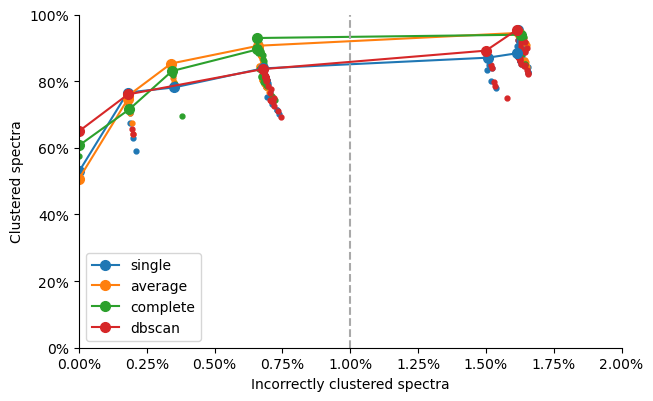

In [17]:

width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

# Hyperparameter optimization.
clustering_pareto_single = get_pareto_frontier(np.column_stack(
    [cluster_hyperparameter_single['prop_clustered_incorrect'], cluster_hyperparameter_single['prop_clustered']]))
ax.plot(clustering_pareto_single[:, 0], clustering_pareto_single[:, 1], marker='o', markersize=7, label='single')
ax.scatter(cluster_hyperparameter_single['prop_clustered_incorrect'], cluster_hyperparameter_single['prop_clustered'], marker='.', s=49)

clustering_pareto_average = get_pareto_frontier(np.column_stack(
    [cluster_hyperparameter_average['prop_clustered_incorrect'], cluster_hyperparameter_average['prop_clustered']]))
ax.plot(clustering_pareto_average[:, 0], clustering_pareto_average[:, 1], marker='o', markersize=7, label='average')
ax.scatter(cluster_hyperparameter_average['prop_clustered_incorrect'], cluster_hyperparameter_average['prop_clustered'], marker='.', s=49)

clustering_pareto_complete = get_pareto_frontier(np.column_stack(
    [cluster_hyperparameter_complete['prop_clustered_incorrect'], cluster_hyperparameter_complete['prop_clustered']]))
ax.plot(clustering_pareto_complete[:, 0], clustering_pareto_complete[:, 1], marker='o', markersize=7, label='complete')
ax.scatter(cluster_hyperparameter_complete['prop_clustered_incorrect'], cluster_hyperparameter_complete['prop_clustered'], marker='.', s=49)

clustering_pareto_dbscan = get_pareto_frontier(np.column_stack(
    [cluster_hyperparameter_dbscan['prop_clustered_incorrect'], cluster_hyperparameter_dbscan['prop_clustered']]))
ax.plot(clustering_pareto_dbscan[:, 0], clustering_pareto_dbscan[:, 1], marker='o', markersize=7, label='dbscan')
ax.scatter(cluster_hyperparameter_dbscan['prop_clustered_incorrect'], cluster_hyperparameter_dbscan['prop_clustered'], marker='.', s=49)

ax.axvline(max_prop_clust_incorrect, c='darkgray', ls='--')

# Performance of optimal hyperparameters on validation set.
# ax.scatter(prop_clust_incorrect_test, prop_clust_test, marker='s', s=49, label='test', zorder=10)

ax.legend()

ax.set_xlim(0, 0.02)
ax.set_ylim(0, 1)

ax.set_xlabel('Incorrectly clustered spectra')
ax.set_ylabel('Clustered spectra')

ax.xaxis.set_major_formatter(mticker.PercentFormatter(1))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))

sns.despine()

plt.savefig('../figures/cluster_hyperparameter_prop_clustered.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


### completeness vs %incorrectly clustered

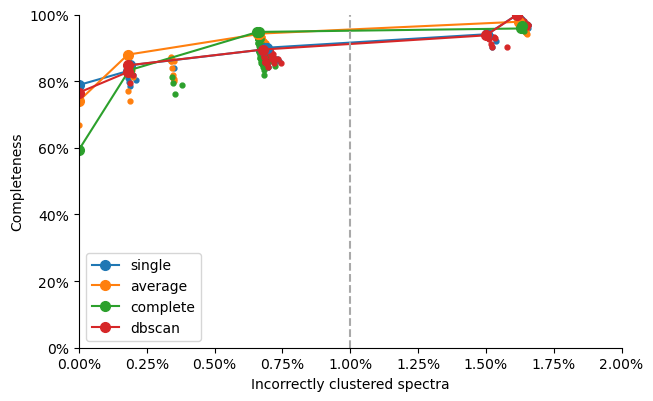

In [18]:

width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

# Hyperparameter optimization.
clustering_pareto_single = get_pareto_frontier(np.column_stack(
    [cluster_hyperparameter_single['prop_clustered_incorrect'], cluster_hyperparameter_single['completeness']]))
ax.plot(clustering_pareto_single[:, 0], clustering_pareto_single[:, 1], marker='o', markersize=7, label='single')
ax.scatter(cluster_hyperparameter_single['prop_clustered_incorrect'], cluster_hyperparameter_single['completeness'], marker='.', s=49)

clustering_pareto_average = get_pareto_frontier(np.column_stack(
    [cluster_hyperparameter_average['prop_clustered_incorrect'], cluster_hyperparameter_average['completeness']]))
ax.plot(clustering_pareto_average[:, 0], clustering_pareto_average[:, 1], marker='o', markersize=7, label='average')
ax.scatter(cluster_hyperparameter_average['prop_clustered_incorrect'], cluster_hyperparameter_average['completeness'], marker='.', s=49)

clustering_pareto_complete = get_pareto_frontier(np.column_stack(
    [cluster_hyperparameter_complete['prop_clustered_incorrect'], cluster_hyperparameter_complete['completeness']]))
ax.plot(clustering_pareto_complete[:, 0], clustering_pareto_complete[:, 1], marker='o', markersize=7, label='complete')
ax.scatter(cluster_hyperparameter_complete['prop_clustered_incorrect'], cluster_hyperparameter_complete['completeness'], marker='.', s=49)

clustering_pareto_dbscan = get_pareto_frontier(np.column_stack(
    [cluster_hyperparameter_dbscan['prop_clustered_incorrect'], cluster_hyperparameter_dbscan['completeness']]))
ax.plot(clustering_pareto_dbscan[:, 0], clustering_pareto_dbscan[:, 1], marker='o', markersize=7, label='dbscan')
ax.scatter(cluster_hyperparameter_dbscan['prop_clustered_incorrect'], cluster_hyperparameter_dbscan['completeness'], marker='.', s=49)

ax.axvline(max_prop_clust_incorrect, c='darkgray', ls='--')

# Performance of optimal hyperparameters on validation set.
# ax.scatter(prop_clust_incorrect_test, prop_clust_test, marker='s', s=49, label='test', zorder=10)

ax.legend()

ax.set_xlim(0, 0.02)
ax.set_ylim(0, 1)

ax.set_xlabel('Incorrectly clustered spectra')
ax.set_ylabel('Completeness')

ax.xaxis.set_major_formatter(mticker.PercentFormatter(1))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))

sns.despine()

plt.savefig('../figures/cluster_hyperparameter_completeness.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
